# **TikTok-User-Engagement-Data**


## Understand the business scenario and problem

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model that can determine whether a video contains a claim or whether it offers an opinion would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

# Import package

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree


# Load dataset

In [2]:
data = pd.read_csv("tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


# Initial Data Exploration

We do a initial data exploration of the dataset to understand more about the dataset we are using. We can learn more about the dataset but finding out the dtypes of the columns, the destributions of the column variables.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [4]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


# Data Cleaning

In [5]:
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

## Check missing values

In [6]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [7]:
# Drop rows with missing values
data = data.dropna(axis=0)

## Check duplicates

In [8]:
# Check for duplicates
data.duplicated().sum()

0

# Comprehensive Data Exploration

To start off, we can find out how many videos are claims and how many are opinions.

In [9]:
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

## Data visualizations

For the predictor variables, we can explore further using boxplots and histograms to find out more about their distributions. At the same time, using boxplots allow us to find outliers in the dataset.

Create a boxplot to visualize distribution of `video_duration_sec`

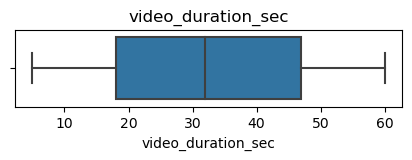

In [10]:
plt.figure(figsize=(5,1))
plt.title('video_duration_sec')
sns.boxplot(x=data['video_duration_sec']);

Create a histogram visualize distribution of `video_duration_sec`

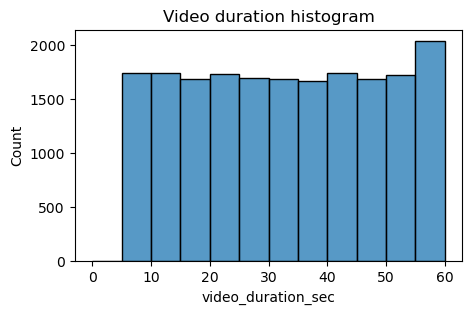

In [11]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_duration_sec'], bins=range(0,61,5))
plt.title('Video duration histogram');

### Insights

All videos are 5-60 seconds in length, and the distribution is uniform.

Create a boxplot to visualize distribution of `video_view_count`

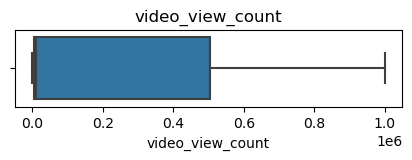

In [12]:
plt.figure(figsize=(5, 1))
plt.title('video_view_count')
sns.boxplot(x=data['video_view_count']);

Create a histogram visualize distribution of `video_view_count`

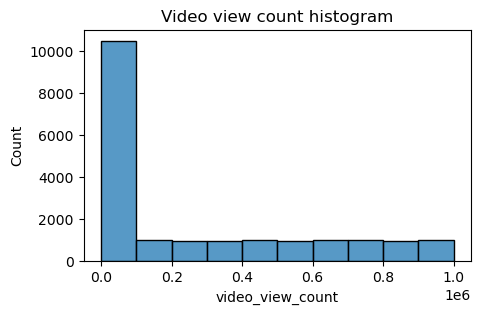

In [13]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_view_count'], bins=range(0,(10**6+1),10**5))
plt.title('Video view count histogram');

### Insights

This variable has a very uneven distribution, with more than half the videos receiving fewer than 100,000 views. Distribution of view counts > 100,000 views is uniform.

Create a boxplot to visualize distribution of `video_like_count`

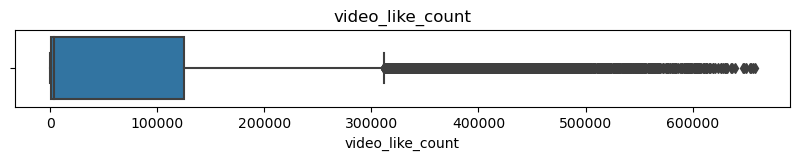

In [14]:
plt.figure(figsize=(10,1))
plt.title('video_like_count')
sns.boxplot(x=data['video_like_count']);

Create a histogram visualize distribution of `video_like_count`

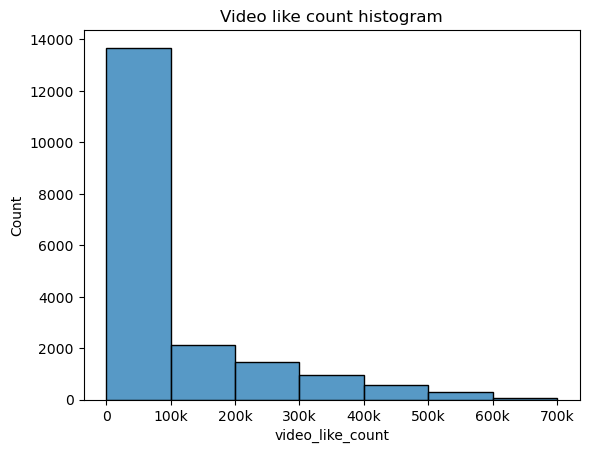

In [15]:
ax = sns.histplot(data['video_like_count'], bins=range(0,(7*10**5+1),10**5))
labels = [0] + [str(i) + 'k' for i in range(100, 701, 100)]
ax.set_xticks(range(0,7*10**5+1,10**5), labels=labels)
plt.title('Video like count histogram');

### Insights

Similar to view count, there are far more videos with < 100,000 likes than there are videos with more. However, in this case, there is more of a taper, as the data skews right, with many videos at the upper extremity of like count.

Create a boxplot to visualize distribution of `video_share_count`

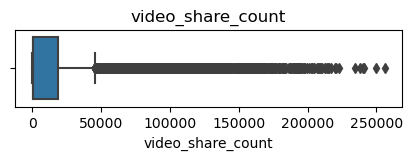

In [16]:
plt.figure(figsize=(5,1))
plt.title('video_share_count')
sns.boxplot(x=data['video_share_count']);

Create a histogram visualize distribution of `video_share_count`

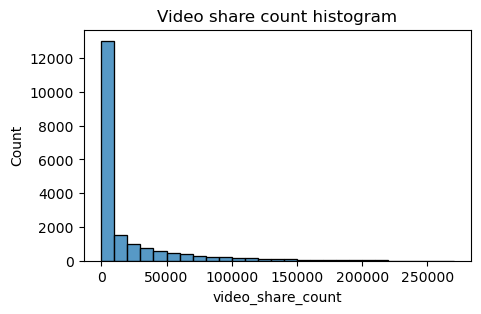

In [17]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_share_count'], bins=range(0,(270001),10000))
plt.title('Video share count histogram');

### Insights

The overwhelming majority of videos had fewer than 10,000 shares. The distribution is very skewed to the right.

Create a boxplot to visualize distribution of `video_download_count`

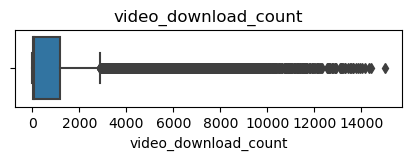

In [18]:
plt.figure(figsize=(5,1))
plt.title('video_download_count')
sns.boxplot(x=data['video_download_count']);

Create a histogram visualize distribution of `video_download_count`

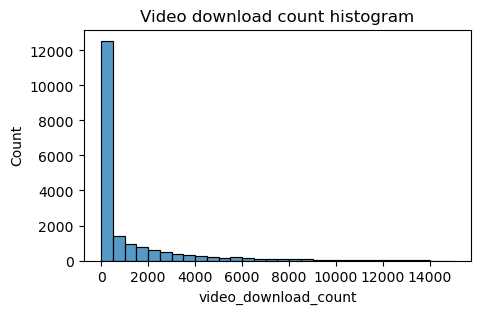

In [19]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_download_count'], bins=range(0,(15001),500))
plt.title('Video download count histogram');

### Insights

The majority of videos were downloaded fewer than 500 times, but some were downloaded over 12,000 times. The data is very skewed to the right.

Create a boxplot to visualize distribution of `video_comment_count`

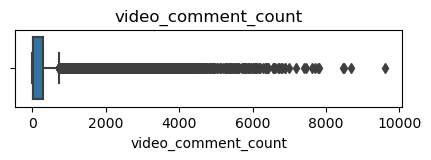

In [20]:
plt.figure(figsize=(5,1))
plt.title('video_comment_count')
sns.boxplot(x=data['video_comment_count']);

Create a histogram visualize distribution of `video_comment_count`

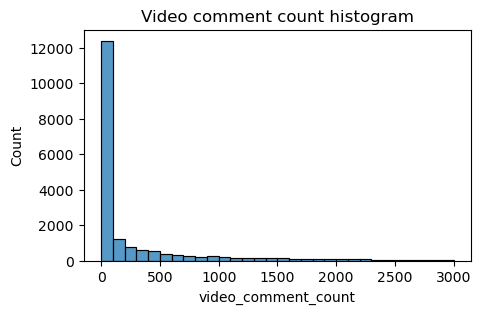

In [21]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_comment_count'], bins=range(0,(3001),100))
plt.title('Video comment count histogram');

### Insights

Almost videos have fewer than 100 comments. The data is very skewed to the right.

Now we plot a histogram of `verified_status` for both claim and opinion. 

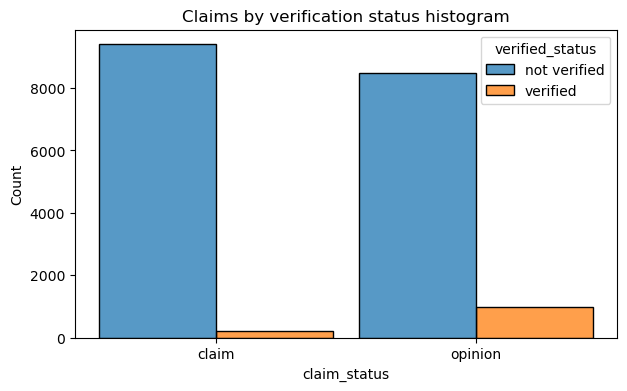

In [22]:
plt.figure(figsize=(7,4))
sns.histplot(data=data,
             x='claim_status',
             hue='verified_status',
             multiple='dodge',
             shrink=0.9)
plt.title('Claims by verification status histogram');

### Insights

There are far fewer verified users than unverified users, but if a user is verified, they are much more likely to post opinions.

Now we plot a histogram of `author_ban_status` for both claim and opinion.

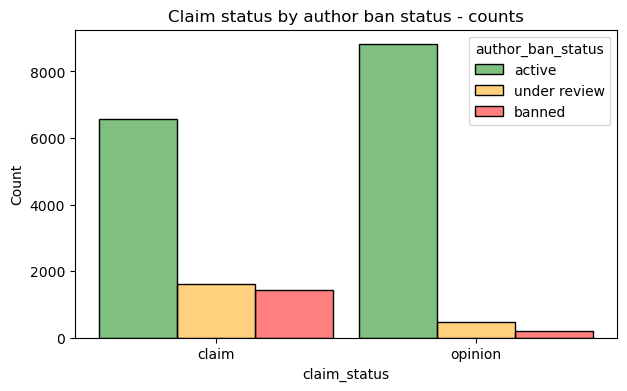

In [23]:
fig = plt.figure(figsize=(7,4))
sns.histplot(data, x='claim_status', hue='author_ban_status',
             multiple='dodge',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette={'active':'green', 'under review':'orange', 'banned':'red'},
             alpha=0.5)
plt.title('Claim status by author ban status - counts');

### Insights

For both claims and opinions, there are many more active authors than banned authors or authors under review. The proportion of active authors is far greater for opinion videos than for claim videos. Authors who post claim videos are also more likely to come under review and/or get banned.

Next, we can create bar plots of median number of views for each of author ban status.

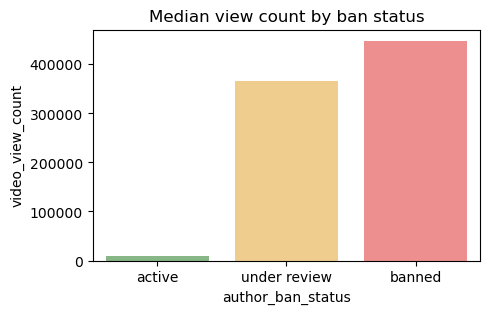

In [24]:
ban_status_counts = data.groupby(['author_ban_status']).median(
    numeric_only=True).reset_index()

fig = plt.figure(figsize=(5,3))
sns.barplot(data=ban_status_counts,
            x='author_ban_status',
            y='video_view_count',
            order=['active', 'under review', 'banned'],
            palette={'active':'green', 'under review':'orange', 'banned':'red'},
            alpha=0.5)
plt.title('Median view count by ban status');

### Insights

The median view counts for non-active authors are many times greater than the median view count for active authors. As non-active authors are more likely to post claims, videos by non-active authors get far more views on aggregate than videos by active authors. As such, `video_view_count` might be a good indicator of claim status. To check for this, we can plot a pie chart.

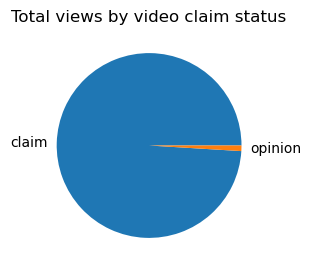

In [25]:
fig = plt.figure(figsize=(3,3))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views by video claim status');

The overall view count is dominated by claim videos even though there are roughly the same number of each video in the dataset.

## Outliers

In [26]:
count_cols = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count',
              ]

for column in count_cols:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    upper_limit= q3 + 1.5*iqr
    lower_limit=q1- 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = data[(data[column]> upper_limit) | (data[column]< lower_limit) ]
    print(f'Number of outliers, {column}:', len(outlier_count))

Number of outliers, video_view_count: 0
Number of outliers, video_like_count: 1726
Number of outliers, video_share_count: 2508
Number of outliers, video_download_count: 2450
Number of outliers, video_comment_count: 2789


In [27]:
data.shape

(19084, 12)

To handle all the outliers, we can set the values of the outliers to the values of the the upper limits instead of removing the them. This does not introduce any bias since values above the upper limits does not represent anything else other than a larger value.

In [28]:
for column in count_cols:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    upper_limit= q3 + 1.5*iqr
    lower_limit=q1- 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    data.loc[data[column] > upper_limit, column] = upper_limit

In [29]:
for column in count_cols:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    upper_limit= q3 + 1.5*iqr
    lower_limit=q1- 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = data[(data[column]> upper_limit) | (data[column]< lower_limit) ]
    print(f'Number of outliers, {column}:', len(outlier_count))

Number of outliers, video_view_count: 0
Number of outliers, video_like_count: 0
Number of outliers, video_share_count: 0
Number of outliers, video_download_count: 0
Number of outliers, video_comment_count: 0


### ** Feature engineering**

Having `video_transcription_text` column is not useful as it is just storing the text contents of the video. Instead, we can extract the length of `video_transcription_text` and use it as a feature in the model called `text_length`


In [30]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average `text_length` for claims and opinions.



In [31]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions using a histogram.

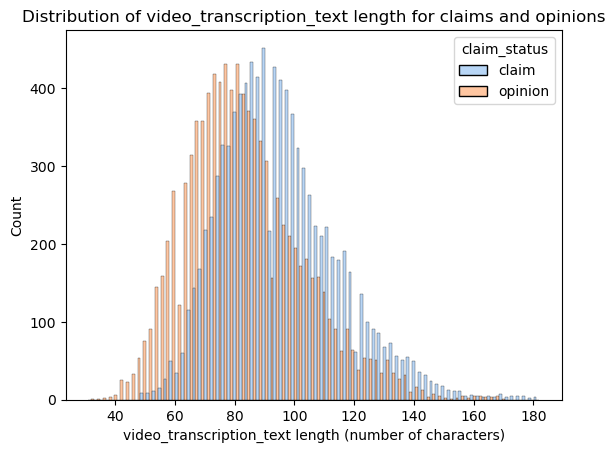

In [32]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

### Insights 

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average.

# Model Building

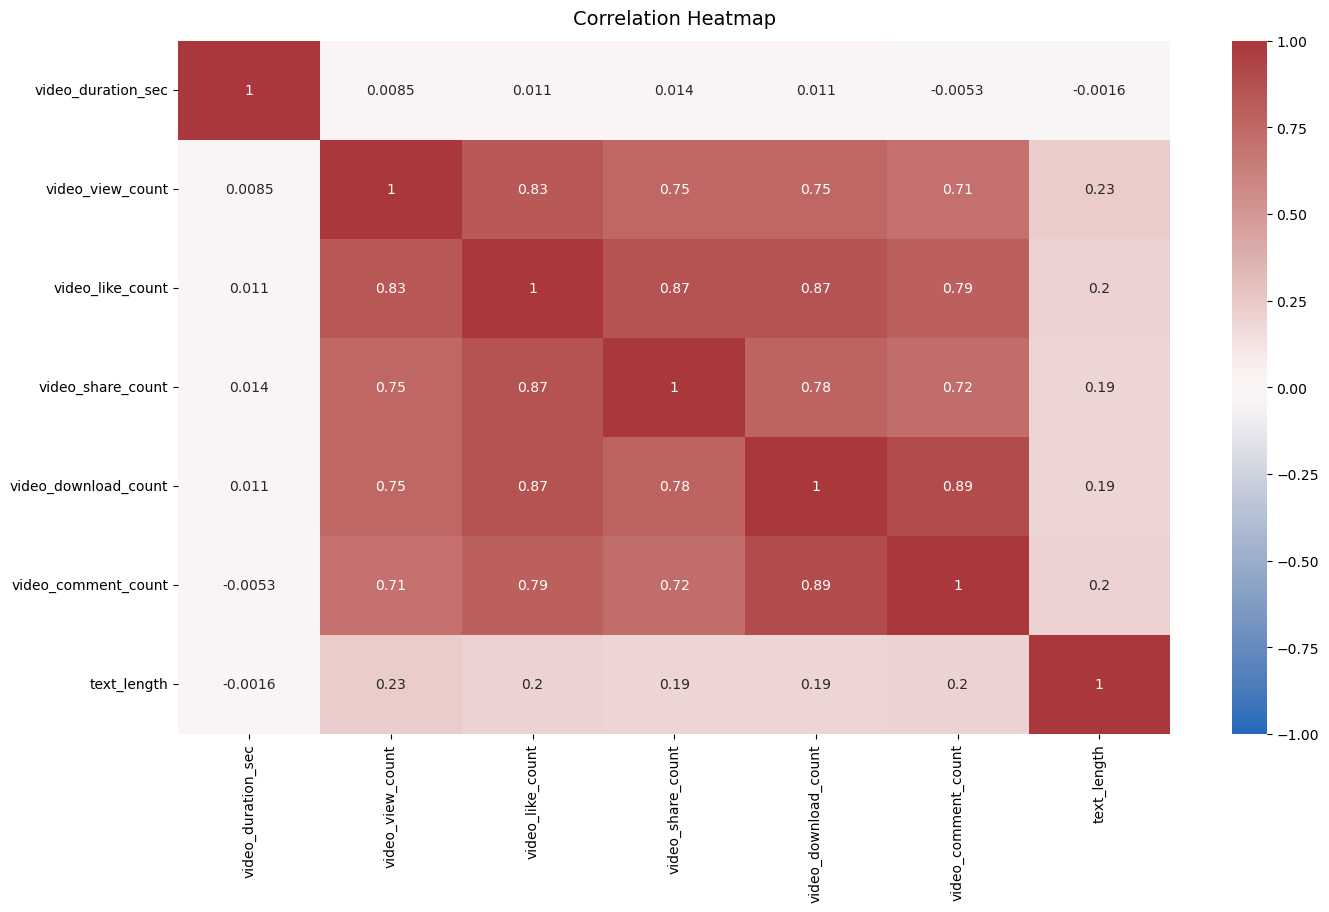

In [33]:
data_copy=data.copy().drop(['#', 'video_id'], axis=1)
numeric_df = data_copy.select_dtypes(include=['number'])

plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

### Insights

The correlation heatmap confirms that video_view_count, video_like_count, video_share_count, video_download_count, and video_comment_count all have strong positive correlation with each other. 

This means that when a video is more videos, it will have more likes, share, downloads and comments. This is as to be expected.

# **Feature Extraction**

Encode target and catgorical variables.

In [45]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Tokenize text column**

Since `video_transcription_text` have text in it, we can also make use of NLP to extract numerical features from it is through a bag-of-words algorithm using `CountVectorizer`.

`CountVectorizer` works by splitting text into n-grams, which are groups of n consecutive words. For instance, "a dime for a cup of coffee" (phrase A) broken into 2-grams would result in six two-word combinations:

`a dime` | `dime for` |`for a`| `a cup` | `cup of` | `of coffee` |

Then, the next sample's text would be parsed into 2-grams. So, "ask for a cup for a child" (phrase B) would result in:

`ask for` |`for a`| `a cup` | `cup for` | `for a` | `a child` |

This process would repeat for each observation in the dataset, and each n-gram would be treated like a distinct feature. Then, the text of each observation is compared to the full array of n-grams, and the numbers of occurrences are tallied:

|  | `a dime` |`dime for`  |`for a`| `a cup` | `cup of` | `of coffee` | `ask for` | `cup for` | `a child` |
|--: |:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|phrase A |1|1|1|1|1|1|0|0|0|
|phrase B |0|0|2|1|1|0|1|1|1|
|**TOTAL**|1|1|3|2|2|1|1|1|1|

This would happen for the text of each observation in the data, and the text of each observation is parsed to get tallies for all the 2-word phrases from the entire data set for each observation, creating a large matrix.

If text is broken into 1-grams, then each feature in the matrix is an individual word.

After the count matrix has been created, `CountVectorizer` lets you the choose to keep only the most frequently occurring n-grams. You specify how many. The n-grams that you select can then be used as features in a model.

Splitting text into n-grams is an example of tokenization. Tokenization is the process of breaking text into smaller units to derive meaning from the resulting tokens.

For this dataset, each video's transcription text into both 2-grams and 3-grams, then takes the 15 most frequently occurring tokens from the entire dataset to use as features.

In [46]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [47]:
# Extract numerical features from `video_transcription_text` 
count_data = count_vec.fit_transform(X['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [48]:
# Place the numerical representation of `video_transcription_text` from into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

count_df.head()

,colleague discovered,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
X = pd.concat([X.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

X.head()

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,...,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,...,0,0,0,0,0,0,0,0,0,0
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,...,0,0,0,0,0,0,0,0,0,0
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,...,0,0,0,0,0,0,0,0,0,0
3,1,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,...,0,0,0,0,0,0,0,0,0,0
4,1,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,...,0,0,0,0,0,0,0,0,0,0


In [50]:
y= X['claim_status']
X=X.drop('claim_status', axis=1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Logistic Regression

For logistic regression, we need to check for model assumptions. These are the assumptions:

- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

Since many of the predictor variables have strong positive correlation with each other, logistic regression model is not suitable for this task.

## Decision Tree

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.

GridSearchCV is used to optimize the hyperparameters of the model and AUC is used as the metric to evaluate the performance of the model. F1 scores are generally used for multiclass classification, on the other hand, AUC performs best for binary classification. Hence, AUC is used.

In [52]:
tree = DecisionTreeClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [53]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 6.41 s
Wall time: 6.41 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [54]:
tree1.best_params_

{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [55]:
tree1.best_score_

0.9972258787805656

In [56]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [57]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [58]:
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.99958,0.992645,0.9961,0.996087,0.997226


In [59]:
tree1_cv_test_scores = get_scores('decision tree cv', tree1, X_test, y_test)
tree1_cv_test_scores

,model,precision,recall,f1,accuracy,AUC
0,decision tree cv,1.0,0.996669,0.998332,0.998323,0.998335


## Random Forest

In [63]:
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

rf_cv=GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit= 'roc_auc')

In [64]:
%%time

rf_cv.fit(X_train, y_train)

CPU times: total: 55min 45s
Wall time: 55min 46s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [65]:
rf_cv.best_score_

0.9987214304011187

In [67]:
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [68]:
rf_cv_results = make_results('random forest cv', rf_cv, 'auc')
rf_cv_results

,model,precision,recall,F1,accuracy,auc
0,random forest cv,1.0,0.991257,0.995608,0.995598,0.998721


In [69]:
rf_cv_test_scores = get_scores('random forest cv', rf_cv, X_test, y_test)
rf_cv_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest cv,1.0,0.995837,0.997914,0.997904,0.997918


## XGBoost model

In [70]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

xgb_cv=GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit= 'roc_auc')

Note this cell might take several minutes to run.

In [71]:
%%time

xgb_cv.fit(X_train, y_train)

CPU times: total: 1min 38s
Wall time: 8.85 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [72]:
xgb_cv.best_score_

0.997992901675361

In [73]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

In [74]:
xgb_cv_results = make_results('random forest cv', xgb_cv, 'auc')
xgb_cv_results

,model,precision,recall,F1,accuracy,auc
0,random forest cv,0.999719,0.988204,0.993927,0.993922,0.997993


In [75]:
xgb_cv_test_scores = get_scores('XGB cv', xgb_cv, X_test, y_test)
xgb_cv_test_scores

,model,precision,recall,f1,accuracy,AUC
0,XGB cv,0.99958,0.990841,0.995191,0.995179,0.995209


## Results and Evaluation

We can store all the test results into a dataframe for comparison.

In [76]:
model_test_scores = pd.concat([rf_cv_test_scores, tree1_cv_test_scores, xgb_cv_test_scores], ignore_index=True)
model_test_scores= model_test_scores.sort_values(by='AUC', ascending=False).reset_index(drop=True)
model_test_scores

,model,precision,recall,f1,accuracy,AUC
0,decision tree cv,1.00000,0.996669,0.998332,0.998323,0.998335
1,random forest cv,1.00000,0.995837,0.997914,0.997904,0.997918
2,XGB cv,0.99958,0.990841,0.995191,0.995179,0.995209


### Summary of model results

After comparing between all the models, decision tree is the best performing model with the highest AUC score. The decision tree model achieved AUC of 99.8%, precision of 100%, recall of 99.7%, f1-score of 99.8%, and accuracy of 99.8%, on the test set which are very good scores. Thus, this model can be used to do prediction for whether a video is a claim or opinion.

Plot a confusion matrix to visualize how well it predicts on the test set.

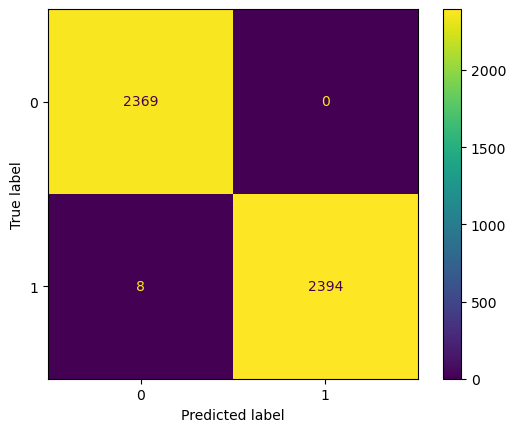

In [77]:
preds = tree1.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=tree1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tree1.classes_)
disp.plot(values_format='');

### Insights

The model predicts 8 false negatives and 0 false positives, which means that some videos may be identified as opinion when it is a claim. Despite this, this is still a strong model for our prediction.

To find out which are the most importance factors in determining if an employee leaves, we can find out the feature importance from all the models

### Decision tree feature importance

In [78]:
tree1_importances = pd.DataFrame(tree1.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree1_importances = tree1_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree1_importances = tree1_importances[tree1_importances['gini_importance'] != 0]
tree1_importances

,gini_importance
video_view_count,0.989840
media claim,0.003045
discussion board,0.002776
internet forum,0.001948
news claim,0.001673
video_like_count,0.000527
video_share_count,0.000135
text_length,0.000056


### Random forest feature importance

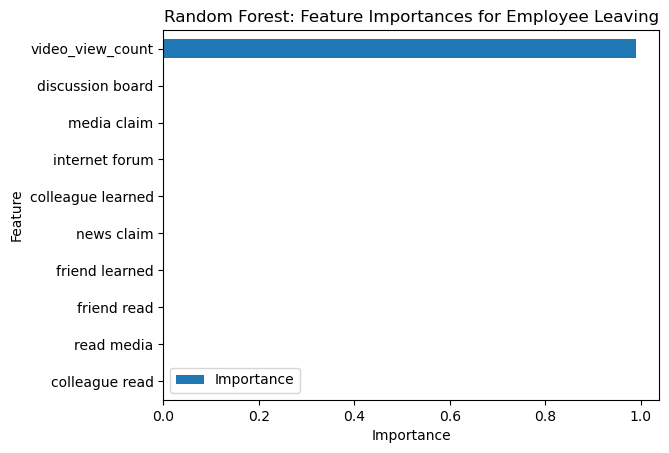

In [79]:
# Get feature importances
feat_impt = rf_cv.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf_cv.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

### XGB feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

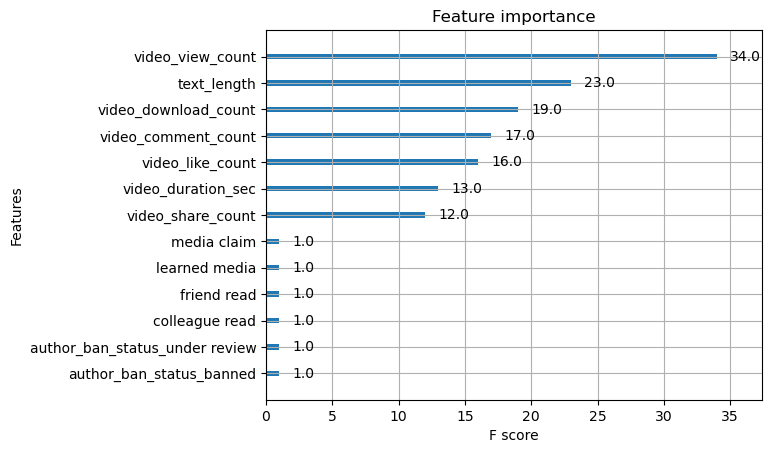

In [80]:
plot_importance(xgb_cv.best_estimator_)

### Insights

All the models shows that video_view_count is the most important feature in predicting whether a video is a claim or opinion. Features that are all related to the user engagement levels associated with each video such as video downloads, video comments, video likes, and video share count can also help in determining if a video is a claim or opinion. Interestingly, words suchs as "media claim" or "news claims" can also help in determining if a video is a claim or opinion. This might be due to trying to cause a controversy, using media or news to "claim" something even though it is entirely made up. Due to such controversy, the video might thus have a high view count and higher user engagement instead of when a video is just putting out an opinion. 